In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from skimage.io import imread, imshow, imsave
from skimage import img_as_ubyte, img_as_float
from scipy.fftpack import dct, idct
from collections import Counter
from copy import deepcopy
import numpy as np
import math

## Third assignment v.1
### Сжатие JPEG
* Своя реализация алгоритма сжатия изображения.
* За основу взять JPEG.
* Но не обязательно брать все его шаги.
* Оценить качество работы алгоритма по PSNR и энтропии.

In [3]:
def make_divisible(img, coef):
    """ Делаем размеры кратными заданному числу """
    r_rem, c_rem = coef - img.shape[0] % coef, coef - img.shape[1] % coef
    # для одного канала
    if type(img[0, 0]) != np.ndarray:
        new = deepcopy(img)
        if c_rem != 8:
            for _ in range(c_rem):
                new = np.c_[new, img[:, -1]]
        if r_rem != 8:
            for _ in range(r_rem):
                new = np.r_[new, [new[-1, :]]]
    # для трехканального изображения
    else:
        R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if c_rem != 8:
            for _ in range(c_rem):
                R, G, B = np.c_[R, R[:, -1]], np.c_[G, G[:, -1]], np.c_[B, B[:, -1]]
        if r_rem != 8:
            for _ in range(r_rem):
                R, G, B = np.r_[R, [R[-1, :]]], np.r_[G, [G[-1, :]]], np.r_[B, [B[-1, :]]]
        new = np.dstack((R, G, B))
    return new

In [4]:
# Unused
def to2(num):
    # Convert to binary
    res = ''
    while num > 1:
        res += str(num % 2)
        num = num // 2
    res += '1'
    return res[::-1]

### Encoding

In [5]:
# 1. RGB to YUV

def rgb2yuv(img):
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    y = 0.299*R + 0.587*G + 0.114*B
    u = -0.1687*R -0.3313*G + 0.5*B + 128
    v = 0.5*R -0.4187*G -0.0813*B + 128
    return y, u, v

In [6]:
# 2. Decimation (encode)

def decimate_encode(u, v, step):

    #indexes for deleting    
    rows, cols = np.array(range(u.shape[0])), np.array(range(u.shape[1]))
    rows_ind = np.delete(rows, rows[step-1::step])
    cols_ind = np.delete(cols, cols[step-1::step])

    # set one of the pixels to be the mean of the block
    for i in range(0, u.shape[0], step):
        for j in range(0, u.shape[1], step):
            u[i+step-1, j+step-1] = np.mean(u[i:(i+step), j:(j+step)])
            v[i+step-1, j+step-1] = np.mean(v[i:(i+step), j:(j+step)])

    # remove all pixels in the blocks except for one
    u, v = np.delete(u, rows_ind, axis=0), np.delete(v, rows_ind, 0)
    u, v = np.delete(u, cols_ind, axis=1), np.delete(v, cols_ind, 1)
    return u, v

In [7]:
# 3. Blocks for each chanel

def blocks(channel, a):
    """ Create a list of (axa) blocks for channel """
    return [channel[i:i+a, j:j+a] for i in range(0, channel.shape[0], a) for j in range(0, channel.shape[1], a)]

In [8]:
# 4. DCT2
# Built-in function

In [9]:
# 5. Quantization

def quantize(box, mtx, coef):
    return np.divide(box, (mtx * coef))

bright = np.array([[16,11,10,16,24,40,51,61], [12,12,14,19,26,58,60,55],
                   [14,13,16,24,40,57,69,56], [14,17,22,29,51,87,80,62],
                   [18,22,37,56,68,109,103,77], [24,35,55,64,81,104,113,92],
                   [49,64,78,87,103,121,120,101], [72,92,95,98,112,100,103,99]])

color = np.array([[17,18,24,47,99,99,99,99], [18,21,26,66,99,99,99,99],
                  [24,26,56,99,99,99,99,99], [47,66,99,99,99,99,99,99],
                  [99,99,99,99,99,99,99,99], [99,99,99,99,99,99,99,99],
                  [99,99,99,99,99,99,99,99], [99,99,99,99,99,99,99,99]])

In [10]:
# 6a. Zigzag bypass

def zigzag_indices(order='direct'):
    """
    Create array of 0, '+' and '-' to determine zig-zag direction.
    Only for 8x8.
    Order: direct (indices 0 to 32);
           inverse (indices 64 to 33)
    """
    row_indices, col_indices = [0], []
    a = '+ ' if order=='direct' else '- '
    b = '+ ' if order=='inverse' else '- '
    
    for i, j in zip(range(2,9,2), range(1,8,2)):
        if i > 6:
            row_indices += (a * 3).split()
        else:
            row_indices += (a * i).split()
            row_indices += (b * i).split()
            row_indices.append(0)
        if j > 5:
            col_indices += (a * j).split()
            col_indices += (b * 3).split()
        else:
            col_indices += (a * j).split()
            col_indices += (b * j).split()
            col_indices.append(0)

    return row_indices, col_indices


def zigzag_encode(box):
    """ Perform a zig-zag bypass for a block """
    DC_AC, inv = [int(box[0, 0])], [int(box[7, 7])]
    for order in ['direct', 'inverse']:
        r, c = zigzag_indices(order)
        i = 0 if order == 'direct' else 7
        j = 0 if order == 'direct' else 7
        for row, col in zip(r, c):
            if row == 0 and col != 0:
                j += 1 if order == 'direct' else -1
            elif row == '+' and col == '-':
                i += 1
                j -= 1
            elif row == '-' and col == '+':
                i -= 1
                j += 1
            elif row != 0 and col == 0:
                i += 1 if order == 'direct' else -1
            DC_AC.append(int(box[i, j])) if order == 'direct' else inv.append(int(box[i, j]))
    DC_AC += reversed(inv)
    return DC_AC

In [11]:
# 6b. DC encode

def DC_encode(arrays):
    """ Encode DC coeffs after zig-zag """
    arrs = deepcopy(arrays)
    for i in range(len(arrs)):
        current = arrs[i][0]
        current -= i if i == 0 else DC_prev
        DC_prev = arrs[i][0]
        arrs[i][0] = current
    return arrs

In [12]:
# 6c. RLE: AC encode

def RLE_encode(array):
    """ Make the (number of zeros before element, element) pairs for AC """
    i, rle = 0, [array[0]]
    for el in array[1:]:
        if el != 0:
            #size = int(np.ceil(np.log2(np.abs(el)))) if np.abs(el) != 1 else 1
            #rle.append([(i, size), el])
            rle.append((i, el))
            i = 0
        else:
            i += 1
    rle.append('EOB')
    return rle

In [13]:
# 6d. Huffman encode

def lowest_prob_pair(p):
    """ Return a pair of symbols from tuple p with lowest probabilities """
    assert(len(p) >= 2)  # Ensure there are at least 2 symbols in the distribution
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    return sorted_p[0][0], sorted_p[1][0]


def huffman(p):
    """
    Return Huffman codes for symbols with given frequency
    Distributions (p): { 'symbol' : frequency }
    Result: { 'symbol' : 'code' }
    """
    # Base case of only two symbols, assign 0 or 1 randomly
    if (len(p) == 2):
        return dict(zip(p.keys(), ['0', '1']))
    if (len(p) == 1):
        return dict(zip(p.keys(), ['0']))
    
    # Create a new distribution by merging lowest probability pair
    pp = deepcopy(p)
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = pp.pop(a1), pp.pop(a2)
    pp[a1 + a2] = p1 + p2

    # Recurse and construct code on a new distribution
    c = huffman(pp)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c


def huffman_encode_DC(rle_channel):
    """ Encode DC for a channel using Huffman method """
    DCs = [str(i[0]) for i in rle_channel]
    DC_freq = dict(Counter(DCs))
    DCh = huffman(DC_freq)
    return DCh


def pairs_huffman_all(rle_channel):
    """ Encode AC for a channel using Huffman method """
    ACh = []
    for box in rle_channel:
        ACh += [i for i in box[1:-1]]
    c = dict(Counter(ACh))
    #del c['none']
    if c == {}:
        return None
    ACh = huffman(c)
    return ACh


def huffman_encode(box, ACh, DCh):
    """ Encode an array for a channel using Huffman method """
    # AC
    if len(box) < 3:
        encoded = deepcopy(box)
    else:
        s = ''
        for pair in [i for i in box[1:-1]]:
            for p in list(ACh.keys()):
                if pair == p:
                    s += ACh[p]
        encoded = [box[0], s, box[-1]]
    # DC
    encoded[0] = DCh[str(encoded[0])]
    return encoded[:-1]

### Decoding (all inversed!)

In [14]:
# 6d. Huffman decode

def dict_rev(d):
    """ Inverse a dictionary """
    return dict(map(lambda x: x[::-1], d.items())) if d is not None else None


def decode_ACs(string, d):
    """ Decode an AC string """
    s = deepcopy(string)
    new, cnt, i = [], 0, s[0]
    while True:
        if i in list(d.keys()):
            new.append(d[i])
            s, cnt = s[len(i):], 0
            try:
                i = s[cnt]
            except IndexError:
                return new
        else:
            cnt += 1
            i += s[cnt]


def huffman_decode(encoded_box, DCh_rev, ACh_rev):
    """ Decode an array for a channel """
    # DC
    decoded = deepcopy(encoded_box)
    decoded[0] = int(DCh_rev[encoded_box[0]])
    # AC
    if len(encoded_box) > 1:
        return [decoded[0]] + decode_ACs(decoded[1], ACh_rev) + ['EOB']
    else:
        return decoded + ['EOB']

In [15]:
# 6c. AC decode

def RLE_decode(array, elements):
    """ Make a list of elements out of a list of pairs """
    res = [array[0]]
    for pair, el in zip(array[1:], elements):
        res += [el] if pair[0] == 0 else [0] * pair[0] + [el]
    res += [0] * (64 - len(res))
    return res

In [16]:
# 6b. DC decode

def DC_decode(arrays):
    """ Decode DC coeffs """
    arrs = deepcopy(arrays)
    for i in range(len(arrs)):
        current = arrs[i][0]
        current += i if i == 0 else DC_prev
        DC_prev = current
        arrs[i][0] = current
    return arrs

In [17]:
# 6a. Zigzag

def zigzag_decode(array):
    """ Create a block of size 8x8 for an array """
    new = np.zeros((8, 8))
    new[0, 0], new[7, 7] = array[0], array[-1]
    r, c = zigzag_indices()
    i, j = 0, 0
    for order in ['direct', 'inverse']:
        cnt = 1
        r, c = zigzag_indices(order)
        i = 0 if order == 'direct' else 7
        j = 0 if order == 'direct' else 7
        for row, col in zip(r, c):
            if row == 0 and col != 0:
                j += 1 if order == 'direct' else -1
            elif row == '+' and col == '-':
                i += 1
                j -= 1
            elif row == '-' and col == '+':
                i -= 1
                j += 1
            elif row != 0 and col == 0:
                i += 1 if order == 'direct' else -1
            new[i, j] = array[cnt] if order == 'direct' else list(reversed(array[32:]))[cnt]
            cnt += 1
    return new

In [18]:
# 5. Dequantization

def dequantize(box, mtx, coef):
    return np.multiply(box, (mtx * coef))

In [19]:
# 4. iDCT2
# Built-in function

In [20]:
# 3. Merge all blocks together

def merge_blocks(blocks, shape):
    """ Merge all blocks together to a channel """
    a = int(len(blocks[0]))
    if len(blocks) < (shape[0]*shape[1])/(a*a):
        r, c = int(np.ceil(shape[0]//2 / a) * a), int(np.ceil(shape[1]//2 / a) * a)
    else:
        r, c = shape[0], shape[1]
    new = np.zeros((r, c))
    cnt = 0
    for i in range(0, r, a):
        for j in range(0, c, a):
            new[i:i+a, j:j+a] = blocks[cnt]
            cnt += 1
    return new

In [21]:
# 2. Decimate (decode)

def decimate_decode(u, v, step):

    # indexes for inserting
    rows, cols = np.array(range(u.shape[0])), np.array(range(u.shape[1]))
    rows_ind, cols_ind = np.array(0), np.array(0)
    for k in rows:
        rows_ind = np.append(rows_ind, [k] * (step-1))
    for k in cols:
        cols_ind = np.append(cols_ind, [k] * (step-1))
    rows_ind, cols_ind = np.delete(rows_ind, 0), np.delete(cols_ind, 0)

    # recreate pixels; not yet assigned to their actual values
    u, v = np.insert(u, rows_ind, 0, axis=0), np.insert(v, rows_ind, 0, axis=0)
    u, v = np.insert(u, cols_ind, 0, axis=1), np.insert(v, cols_ind, 0, axis=1)

    # assigning
    for i in range(0, u.shape[0], step):
        for j in range(0, u.shape[1], step):
            u[i:(i+step), j:(j+step)] = u[i+step-1, j+step-1]
            v[i:(i+step), j:(j+step)] = v[i+step-1, j+step-1]
    
    return u, v


def restore_shape(channel, shape):
    # crop unwanted rows or columns after decimation
    return channel[:int(shape[0]), :int(shape[1])]

In [22]:
# 1. YUV to RGB

def yuv2rgb(Y, U, V):
    R = np.clip(Y + 1.402*(V - 128), 0, 255)
    G = np.clip(Y -0.34414*(U - 128) -0.71414*(V - 128), 0, 255)
    B = np.clip(Y + 1.772*(U - 128), 0, 255)
    new = np.dstack((R, G, B))
    return np.int_(new)

### JPEG

In [23]:
def jpeg_encode(image, qm):
    """
    Encode an image using a JPEG algorithm.
    Qm (int) is multiplied with quantize matrix to increase the compression ratio.
    """
    img = make_divisible(image, 8)
    shape = img.shape[0], img.shape[1]
    # 1, 2
    Y, U, V = rgb2yuv(img)
    U, V = decimate_encode(U, V, 2)
    U, V = make_divisible(U, 8), make_divisible(V, 8)
    Y, U, V = Y-128, U-128, V-128
    # 3
    Y_boxes, U_boxes, V_boxes = blocks(Y, 8), blocks(U, 8), blocks(V, 8)
    # 4
    Y_dct = [dct(dct(box.T, norm='ortho').T, norm='ortho') for box in Y_boxes]
    U_dct = [dct(dct(box.T, norm='ortho').T, norm='ortho') for box in U_boxes]
    V_dct = [dct(dct(box.T, norm='ortho').T, norm='ortho') for box in V_boxes]
    # 5
    Y_qua = [quantize(box, bright, qm) for box in Y_dct]
    U_qua = [quantize(box, color, qm) for box in U_dct]
    V_qua = [quantize(box, color, qm) for box in V_dct]
    # 6a Zigzag
    Y_z = [zigzag_encode(box) for box in Y_qua]
    U_z = [zigzag_encode(box) for box in U_qua]
    V_z = [zigzag_encode(box) for box in V_qua]
    # 6b DC difference
    Y_acdc = DC_encode(Y_z)
    U_acdc = DC_encode(U_z)
    V_acdc = DC_encode(V_z)
    # 6c RLE for AC with DC encoded in the beginning
    Y_rle = [RLE_encode(array) for array in Y_acdc]
    U_rle = [RLE_encode(array) for array in U_acdc]
    V_rle = [RLE_encode(array) for array in V_acdc]
    # 6d Huffman for DC and AC
    Y_dcs, Y_acs = huffman_encode_DC(Y_rle), pairs_huffman_all(Y_rle)
    Y_huff = [huffman_encode(array, Y_acs, Y_dcs) for array in Y_rle]
    Y_data = [Y_dcs, Y_acs, Y_huff]
    U_dcs, U_acs = huffman_encode_DC(U_rle), pairs_huffman_all(U_rle)
    U_huff = [huffman_encode(array, U_acs, U_dcs) for array in U_rle]
    U_data = [U_dcs, U_acs, U_huff]
    V_dcs, V_acs = huffman_encode_DC(V_rle), pairs_huffman_all(V_rle)
    V_huff = [huffman_encode(array, V_acs, V_dcs) for array in V_rle]
    V_data = [V_dcs, V_acs, V_huff]

    return Y_data, U_data, V_data, shape

In [24]:
def jpeg_decode(Y_data, U_data, V_data, shape, qm):
    """ Decode encoded image data using a JPEG algorithm. """
    # 6d
    Y_dcs, Y_acs, Y_huff = Y_data
    Y_decoded = [huffman_decode(array, dict_rev(Y_dcs), dict_rev(Y_acs)) for array in Y_huff]
    U_dcs, U_acs, U_huff = U_data
    U_decoded = [huffman_decode(array, dict_rev(U_dcs), dict_rev(U_acs)) for array in U_huff]
    V_dcs, V_acs, V_huff = V_data
    V_decoded = [huffman_decode(array, dict_rev(V_dcs), dict_rev(V_acs)) for array in V_huff]
    # 6c
    Y_acdc = [RLE_decode([i for i in array], [i[1] for i in array[1:-1]]) for array in Y_decoded]
    U_acdc = [RLE_decode([i for i in array], [i[1] for i in array[1:-1]]) for array in U_decoded]
    V_acdc = [RLE_decode([i for i in array], [i[1] for i in array[1:-1]]) for array in V_decoded]
    # 6b
    Y_z = DC_decode(Y_acdc)
    U_z = DC_decode(U_acdc)
    V_z = DC_decode(V_acdc)
    # 6a
    Y_qua = [zigzag_decode(box) for box in Y_z]
    U_qua = [zigzag_decode(box) for box in U_z]
    V_qua = [zigzag_decode(box) for box in V_z]
    # 5
    Y_dct = [dequantize(box, bright, qm) for box in Y_qua]
    U_dct = [dequantize(box, color, qm) for box in U_qua]
    V_dct = [dequantize(box, color, qm) for box in V_qua]
    # 4
    Y_boxes = [idct(idct(box.T, norm='ortho').T, norm='ortho') for box in Y_dct]
    U_boxes = [idct(idct(box.T, norm='ortho').T, norm='ortho') for box in U_dct]
    V_boxes = [idct(idct(box.T, norm='ortho').T, norm='ortho') for box in V_dct]
    # 3
    Y, U, V = merge_blocks(Y_boxes, shape), merge_blocks(U_boxes, shape), merge_blocks(V_boxes, shape)
    Y, U, V = Y+128, U+128, V+128
    # 2
    U, V = decimate_decode(U, V, 2)
    U, V = restore_shape(U, shape), restore_shape(V, shape)
    # 1
    new = yuv2rgb(Y, U, V)
    
    return new

### Tests

(491, 750, 4)


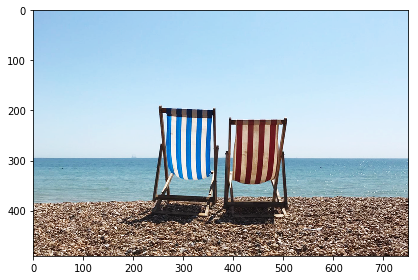

In [25]:
#path = 'img/tiger-color.png'
path = 'singles.PNG'
image = imread(path)
print(image.shape)
if image.shape[2] == 4:
    image = image[:,:,:3]
imshow(image);

In [31]:
qm = 4
Y_data, U_data, V_data, shape = jpeg_encode(image, qm)

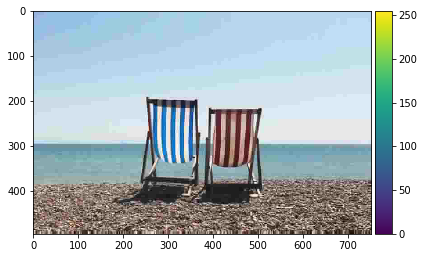

In [32]:
new = jpeg_decode(Y_data, U_data, V_data, shape, qm)
imshow(new);

In [33]:
#imsave('JJ.jpeg', new)

### Оценка

In [44]:
# весовое суммирование после кодирования jpeg
# TO DO: Энтропия 6 выходных данных после jpeg_encode для потока AC и для потока DC
def entropy_encode(b):
    H = 0
    _, quantity = np.unique(b, return_counts=True)
    p = quantity / len(b)
    for i in p:
        H += (-i) * np.log(i)
    return H


def entropy(img):
    values, _ = np.histogram(img, bins=range(257))
    probs = values / img.size
    return -sum(p_i * np.log(p_i) for p_i in probs if p_i != 0)


def rmse(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2) / img1.size)


def PSNR(img1, img2):
    RMSE = rmse(img1, img2)
    return 20 * math.log10(255/RMSE)

In [35]:
print('Entropy before:', entropy(image))
print('Entropy after: ', entropy(new))
print('PSNR of images:', PSNR(image, new[:image.shape[0], :image.shape[1]]))

Entropy before: 5.167376375182635
Entropy after:  4.714506886831734
PSNR of images: 22.489673981552116


In [49]:
len(Y_data[0]), len(Y_data[1]), len(Y_data[2]), \
len(U_data[0]), len(U_data[1]), len(U_data[2]), \
len(V_data[0]), len(V_data[1]), len(V_data[2])

(35, 132, 5828, 7, 15, 1457, 7, 17, 1457)

In [46]:
entropy_encode(Y_data[0]) 

0.10158137318541181

Работает!